In [1]:
import rasterio
from rasterio.transform import array_bounds
from rasterio import plot
import geopandas as gpd
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

from pathlib import Path
from tqdm import tqdm

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import colors, colorbar, cm
from matplotlib.colors import LinearSegmentedColormap

from orinoco import get_cropped_profile, get_features_from_array

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=25)

In [2]:
tile_name = 'NR08'

In [3]:
out = Path('out')

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

In [4]:
out = Path('out')
grwl_data = Path('grwl_data')

tile_dir = out/tile_name
tile_dir_4326 = out/f'{tile_name}_4326'

In [5]:
list(tile_dir_4326.glob('*'))

[PosixPath('out/NR08_4326/segments_NR08.tif'),
 PosixPath('out/NR08_4326/distance_NR08.tif'),
 PosixPath('out/NR08_4326/ocean_mask_NR08.tif'),
 PosixPath('out/NR08_4326/segments_rgb_NR08.tif'),
 PosixPath('out/NR08_4326/water_mask_dilated_NR08.tif'),
 PosixPath('out/NR08_4326/width_differences.tif'),
 PosixPath('out/NR08_4326/water_mask_NR08.tif')]

In [6]:
with rasterio.open(tile_dir_4326/f'segments_{tile_name}.tif') as ds:
    segments = ds.read(1)
with rasterio.open(tile_dir_4326/f'ocean_mask_{tile_name}.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(tile_dir_4326/f'segments_{tile_name}.tif') as ds:
    segments = ds.read(1)
    
with rasterio.open(tile_dir_4326/f'width_differences.tif') as ds:
    width_differences = ds.read(1)
    
with rasterio.open(tile_dir_4326/f'water_mask_{tile_name}.tif') as ds:
    water_mask = ds.read(1)
    profile= ds.profile

ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

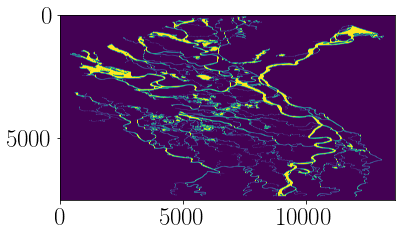

In [7]:
plt.imshow(water_mask)

/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


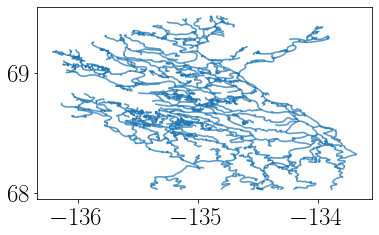

In [8]:
edges_grwl = gpd.read_file(grwl_data/'centerlines'/tile_name)
widths_df = gpd.read_file(tile_dir/'width_geometries.geojson').to_crs({'init':'epsg:4326'})
edges_orinoco = gpd.read_file(tile_dir/f'{tile_name}_edges.geojson').to_crs({'init':'epsg:4326'})
edges_orinoco.plot()

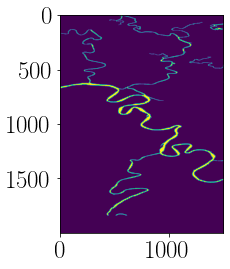

In [9]:
sy = np.s_[5_500:7_500]
sx = np.s_[7_000:8_500]
plt.imshow(water_mask[sy, sx])

In [10]:
slice_index = 0

In [11]:
# Mackenzie
figsize=(12, 10)

if (tile_name is 'NR08') & (slice_index == 0):
    sy = np.s_[2_000:3_000]
    sx = np.s_[4_000:5_000]
    loc='upper left'

elif (tile_name is 'NR08') & (slice_index == 1):
    sy = np.s_[5_600:6_600]
    sx = np.s_[7_750:8_750]
    loc='lower right'

plot_dir = Path(f'plot/{tile_name}_{slice_index}')
plot_dir.mkdir(exist_ok=True, parents=True)

In [12]:
profile_cropped = get_cropped_profile(profile, sx, sy)


In [13]:
profile_cropped = get_cropped_profile(profile, sx, sy)
transform_c = profile_cropped['transform']
x_min, y_min, x_max, y_max = array_bounds(profile_cropped['height'], 
                                          profile_cropped['width'], 
                                          profile_cropped['transform'])

In [14]:
edges_grwl_c = edges_grwl.cx[x_min: x_max, y_min: y_max].copy()
edges_orinoco_c = edges_orinoco.cx[x_min: x_max, y_min: y_max].copy()
widths_df_c = widths_df.cx[x_min: x_max, y_min: y_max].copy()

ocean_layer_c = ocean_layer[sy, sx]
water_mask_c = water_mask[sy, sx]

In [15]:
M = 4
labels = ['Land', 'Inland Water', 'Ocean', 'Orinoco']

cNorm  = colors.Normalize(vmin=0, vmax=(M))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          markersize=10) for k in range(M-1)] +\
                  [Line2D([0], 
                          [0], 
                          marker=None,
                          color=scalarMap.to_rgba(M),
                          label=f'{labels[M-1]}',
                          linewidth=5,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

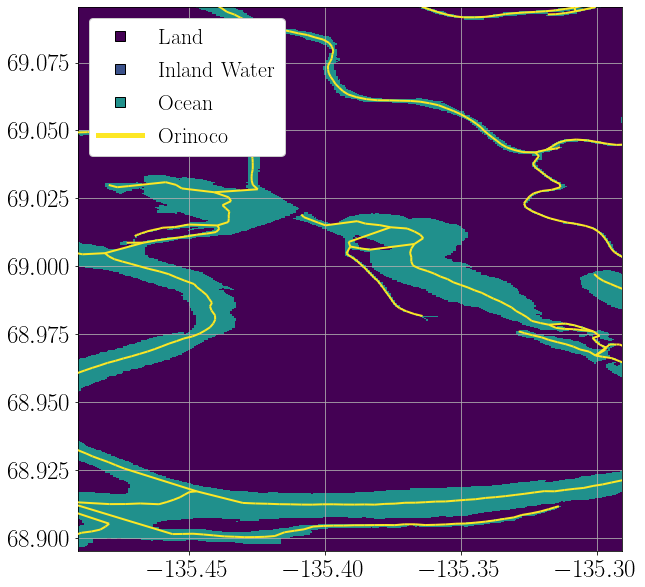

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=1)

plot.show(ocean_layer_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=1)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

edges_orinoco_c.plot(edgecolor=scalarMap.to_rgba(4),
                     linewidth=2,
                     ax=ax,
                     zorder = 3) 
                  

ax.legend(handles=legend_elements, loc=loc, fontsize=22, framealpha=1)
ax.grid('on')

plt.savefig(plot_dir/'orinoco.png')

In [17]:
M = 4
labels = ['Land', 'Inland Water', 'Ocean', 'GRWL']

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          markersize=10) for k in range(M-1)] +\
                  [Line2D([0], 
                          [0], 
                          marker=None,
                          color=scalarMap.to_rgba(M),
                          label=f'{labels[M-1]}',
                          linewidth=5,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

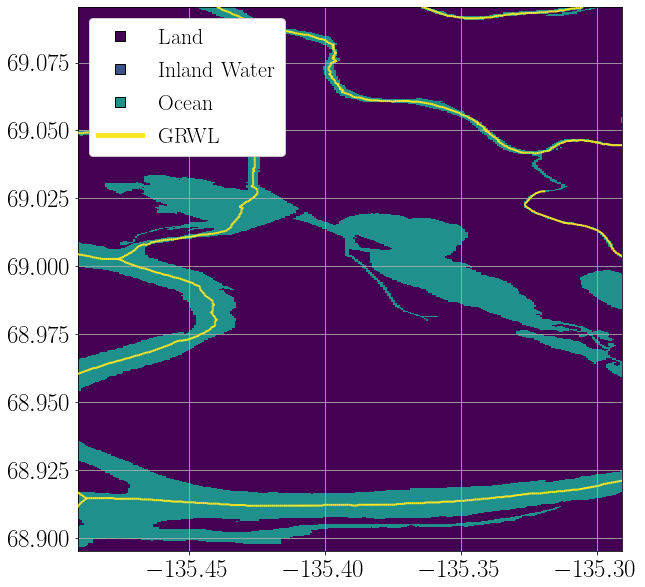

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=1)

plot.show(ocean_layer_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=1)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

edges_grwl_c.plot(edgecolor=scalarMap.to_rgba(4),
                  linewidth=2,
                  ax=ax,
                  zorder = 3) 
                  
ax.legend(handles=legend_elements, loc=loc, fontsize=22, framealpha=1)
ax.grid('on')

plt.savefig(plot_dir/'grwl.png')


In [19]:
M = 1

cNorm  = colors.Normalize(vmin=0, vmax=(M))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'No data',
                          markerfacecolor=scalarMap.to_rgba(1),
                          markeredgecolor='black',
                          markersize=10) ] +\
                  [Line2D([0], 
                          [0], 
                          marker=None,
                          color='green',
                          label=f'Width',
                          linewidth=2,
                          markersize=10)]

In [20]:
import scipy.ndimage as nd
mask_crop = water_mask[sy, sx]
outline_c = nd.morphology.binary_dilation(mask_crop, iterations = 3).astype(float)
outline_c[mask_crop.astype(bool)] = 0.
outline_c[outline_c == 0] = np.nan

nodata_diff = (water_mask & np.isnan(width_differences)).astype(float)
nodata_diff[nodata_diff == 0] = np.nan

In [21]:
nodata_diff_c = nodata_diff[sy, sx]
width_differences_c = width_differences[sy, sx]

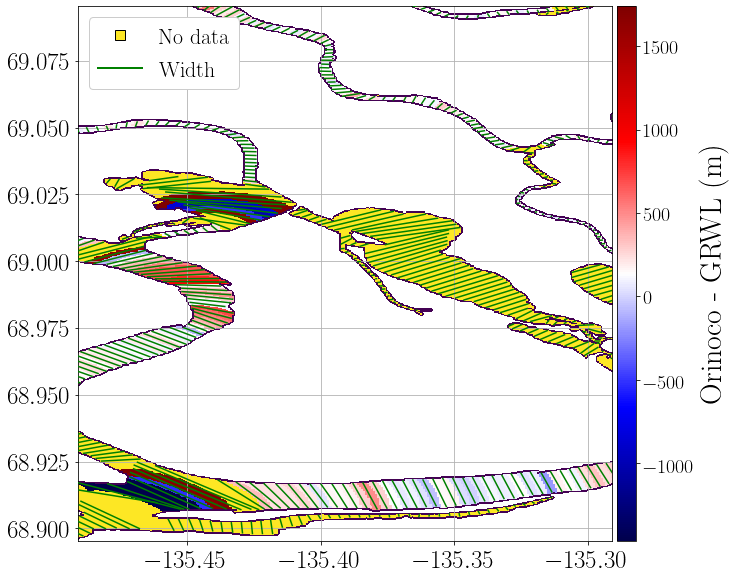

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap='seismic'
plot.show(width_differences_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          cmap=cmap,
          vmin=-500,
          vmax=500,
          interpolation='none')

plot.show(nodata_diff_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=1,
          interpolation='none')

plot.show(outline_c, 
          ax=ax, 
          transform=transform_c,
          interpolation='none')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

    
widths_df_c.plot(color='green', ax=ax, alpha=1,zorder=4)

##########
# Colorbar
##########

# Source: https://matplotlib.org/3.1.0/tutorials/colors/colorbar_only.html

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3.5%', pad=0.07)

norm = colors.Normalize(vmin=np.nanmin(width_differences_c), vmax=np.nanmax(width_differences_c))
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel('Orinoco - GRWL (m)', fontsize=30)
cax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(handles=legend_elements, loc=loc, fontsize=22, framealpha=1)
ax.grid('on')
plt.savefig(plot_dir/'width_differences.png')

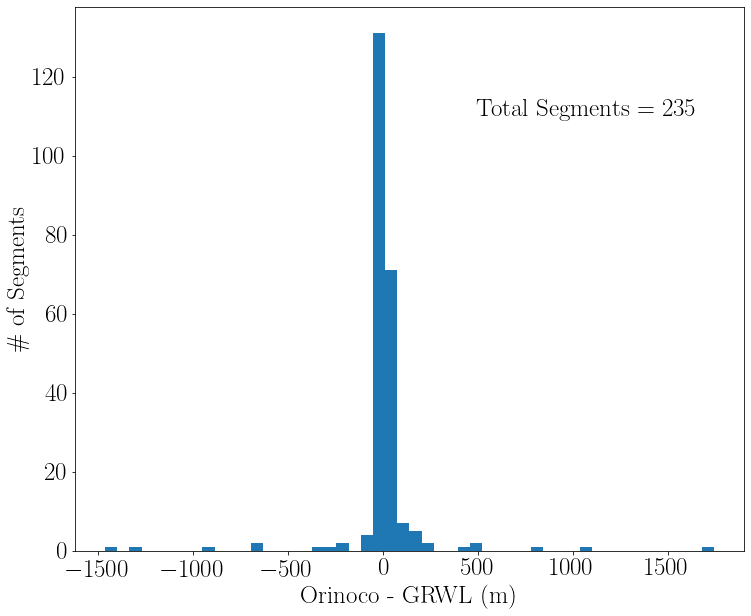

In [23]:
fig, ax = plt.subplots(figsize=figsize)
X = width_differences[sy, sx]
labels = segments[sy, sx]
data = get_features_from_array(labels, X)
data = data[~np.isnan(data)]
ax.hist(data, bins=50)
ax.set_xlabel('Orinoco - GRWL (m)')
ax.set_ylabel('\# of Segments')
ax.text(.6, .8, f'Total Segments = {len(data):,}', transform=ax.transAxes)
plt.savefig(plot_dir/'diff_histogram.png')